# Convolutional deep autoencoder on mnist

# Tensorflow version

This is an example of training w

This is an experiment training a convolutional autoencoder on the MNIST database using keras.

This is heavily inspired by [this blog article](https://swarbrickjones.wordpress.com/2015/04/29/convolutional-autoencoders-in-pythontheanolasagne/), but it uses keras instead of Lasagne.

We experiment with 10 and 2 neurons in the representation layer (the deepest layer).

Thanks to [@isaacgerg](https://github.com/isaacgerg) for his help fixing some issues.

### Imports and utility functions

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32'
os.environ['THEANO_FLAGS']='mode=FAST_COMPILE,device=cpu,floatX=float32'
#os.environ['THEANO_FLAGS']='device=gpu0'

In [103]:
from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import itertools
import numpy as np
import theano.tensor as T
np.random.seed(1337) # for reproducibility

from keras.datasets import mnist
from keras.layers.noise import GaussianNoise
import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Merge, InputSpec
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from keras.regularizers import ActivityRegularizer

from keras import backend as K

In [6]:
np.set_printoptions(precision=5, suppress=True)

In [7]:
%matplotlib inline

In [8]:
# Some utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    
    
def compare_input_reconstruction(input_img, rec_img, repr_activation, clsname='', fig=None):
    """
    Utility function to show input digit and autoencoder reconstruction
    
    Args:
        input_img: A 2D input image
        rec_img: The 2D reconstructed image
        repr_activation: The activation of the representation neurons
    """
    if fig is None:
        fig = pl.figure(figsize=(15, 5))
    ax = pl.subplot(131)
    ax.set_title('input image (class = %s)' % clsname)
    nice_imshow(ax, input_img, vmin=0, vmax=1, cmap=cm.binary)
     
    ax = pl.subplot(132)
    ax.set_title('reconstruction')
    nice_imshow(ax, rec_img, vmin=0, vmax=1, cmap=cm.binary)
    
    ax = pl.subplot(133)
    
    bar_centers = np.arange(len(repr_activation))
    ax.set_title('representation neurons activation')
    ax.bar(bar_centers, repr_activation, width=0.8, align='center')
    pl.xticks(bar_centers, bar_centers)
    pl.xlim((-0.5, bar_centers[-1] + 0.5))
    
    pl.tight_layout()

In [99]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_train, y_train = X_train[:10000], y_train[:10000]

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


label :  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


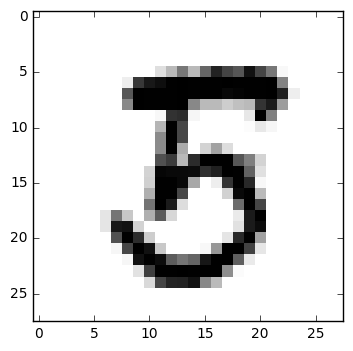

In [10]:
i = 4600
pl.imshow(X_train[i, 0], interpolation='nearest', cmap=cm.binary)
print("label : ", Y_train[i,:])

In [11]:
X_train.shape

(60000, 1, 28, 28)

## Autoencoder with 10 representation units

This part trains an autoencoder with two convolutional layers and 10 neurons at the representation (deepest) layer. We use linear activation everywhere.

In [112]:
# TODO: For some reason, this doesn't do the exact same thing as UpSampling2D. Not sure why
class UnPooling2D(Layer):
    """A 2D Repeat layer"""
    input_ndim = 4
    
    def __init__(self, size=(2, 2), dim_ordering='default', **kwargs):
        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()
        #self.set_input(K.placeholder(ndim=4))
        self.input_spec = [InputSpec(ndim=4)]
        self.size = tuple(size)
        assert dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'
        self.dim_ordering = dim_ordering
        super(UnPooling2D, self).__init__(**kwargs)
        
    @property
    def output_shape_for(self, input_shape):
        #input_shape = self.input_shape
        if self.dim_ordering == 'th':
            width = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            height = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    width,
                    height)
        elif self.dim_ordering == 'tf':
            width = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            height = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    width,
                    height,
                    input_shape[3])
        else:
            raise Exception('Invalid dim_ordering: ' + self.dim_ordering)
            
            
    def call(self, x, mask=None):
        #X = self.get_input(train)
        #s1 = self.poolsize[0]
        #s2 = self.poolsize[1]
        #output = X.repeat(s1, axis=2).repeat(s2, axis=3)
        #return output
    
        if self.dim_ordering == 'th':
            output = K.repeat_elements(x, self.size[0], axis=2)
            output = K.repeat_elements(output, self.size[1], axis=3)
        elif self.dim_ordering == 'tf':
            output = K.repeat_elements(x, self.size[0], axis=1)
            output = K.repeat_elements(output, self.size[1], axis=2)
        else:
            raise Exception('Invalid dim_ordering: ' + self.dim_ordering)
        return output


    def get_config(self):
        config = {'size': self.size, "poolsize": self.poolsize}
        base_config = super(UpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [76]:
# - Build the encoder pipeline
def create_encoding_layers():
    return [
        Convolution2D(32, 5, 5, border_mode='valid'),
        MaxPooling2D(pool_size=(2, 2)),
        Convolution2D(32, 3, 3, border_mode='valid'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128),
        Dense(10),
    ]

def create_decoding_layers():
    return[
        Dense(128),
        Dense(32*5*5),
        Reshape(target_shape=(32, 5, 5)),
        UpSampling2D(size=(2,2)),
        #UnPooling2D(size=(2,2)),
        ZeroPadding2D(padding=(1,1)),
        Convolution2D(32, 3, 3, border_mode='same'),
        UpSampling2D(size=(2,2)),
        #UnPooling2D(size=(2,2)),
        ZeroPadding2D(padding=(2,2)),
        Convolution2D(1, 5, 5, border_mode='same'),
    ]

autoencoder = models.Sequential()
# Add a noise layer to get a denoising autoencoder. This helps avoid overfitting
#autoencoder.add(Layer(input_shape=(1, 28, 28)))

autoencoder.add(GaussianNoise(sigma=0.3, input_shape=(1, 28, 28)))
autoencoder.encoding_layers = create_encoding_layers()
autoencoder.decoding_layers = create_decoding_layers()
for l in autoencoder.encoding_layers:
    autoencoder.add(l)
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01, momentum=0.8, decay=0., nesterov=False)
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta', metrics=["accuracy"])

We display a graphical representation of the autoencoder. 
You can see that the last layer has an output shape of 10.

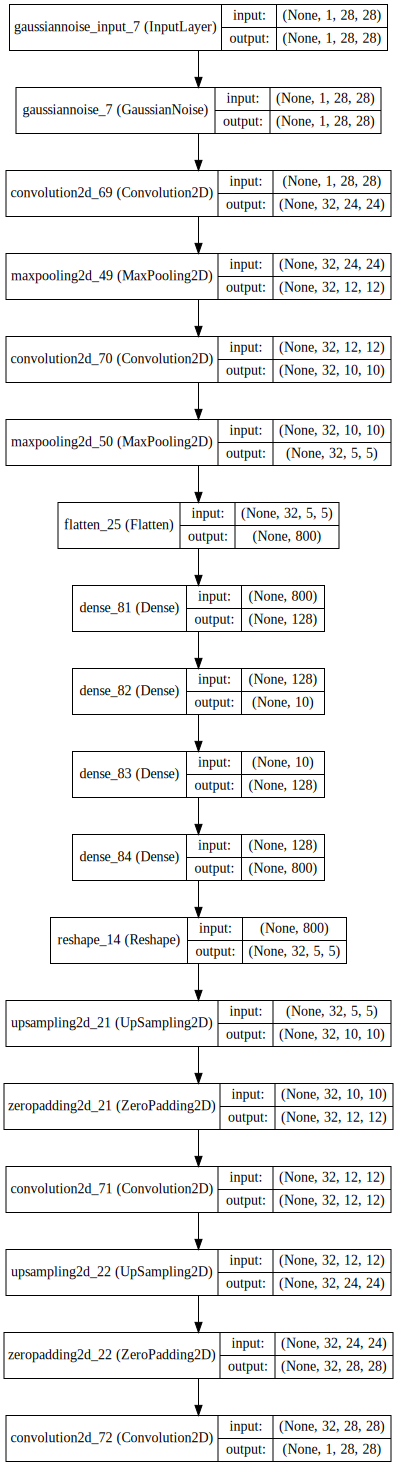

In [77]:
import keras.utils.visualize_util as vutil
from IPython.display import SVG

#SVG(vutil.model_to_dot(autoencoder, recursive=True, show_shape=True).create(prog='dot', format="svg"))
SVG(vutil.model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format="svg"))

A theano function to get the representation of a given input (without reconstructing it)

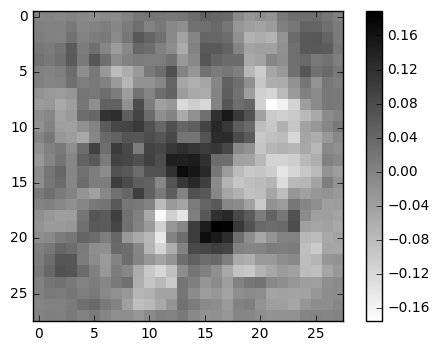

In [78]:
# Of course we'll get random results here because this is with an untrained autoencoder
X_pred = autoencoder.predict([X_train[0:5]])

pl.imshow(X_pred[0].squeeze(), interpolation='nearest', cmap=cm.binary)
pl.colorbar()

Ok, so let's train it

In [79]:
nb_epoch = 10
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch,
                          verbose=1, validation_data=(X_test, X_test))
print("*** HERE ***")
score = autoencoder.evaluate(X_test, X_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 46s - loss: 0.0443 - acc: 0.1512 - val_loss: 0.0376 - val_acc: 0.1717
Epoch 2/10
60000/60000 [==============================] - 46s - loss: 0.0377 - acc: 0.1720 - val_loss: 0.0362 - val_acc: 0.1752
Epoch 3/10
60000/60000 [==============================] - 46s - loss: 0.0370 - acc: 0.1750 - val_loss: 0.0366 - val_acc: 0.1772
Epoch 4/10
60000/60000 [==============================] - 46s - loss: 0.0367 - acc: 0.1773 - val_loss: 0.0359 - val_acc: 0.1808
Epoch 5/10
60000/60000 [==============================] - 46s - loss: 0.0364 - acc: 0.1789 - val_loss: 0.0353 - val_acc: 0.1835
Epoch 6/10
60000/60000 [==============================] - 46s - loss: 0.0362 - acc: 0.1799 - val_loss: 0.0354 - val_acc: 0.1812
Epoch 7/10
60000/60000 [==============================] - 46s - loss: 0.0362 - acc: 0.1804 - val_loss: 0.0353 - val_acc: 0.1813
Epoch 8/10
60000/60000 [==============================

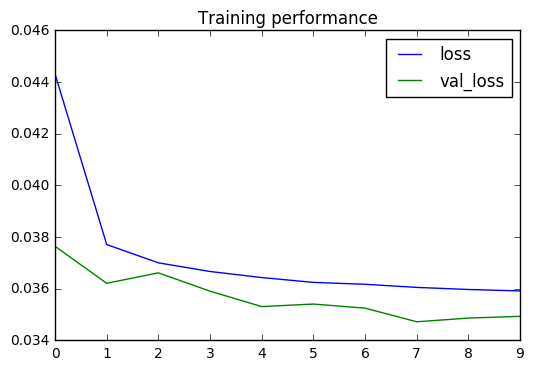

In [80]:
pl.figure()
pl.title('Training performance')
pl.plot(history.epoch, history.history['loss'], label='loss')
pl.plot(history.epoch, history.history['val_loss'], label='val_loss')
pl.legend()

In [84]:
# Build an encoder-only by copying the weights
encoder = models.Sequential()
encoder.add(Layer(input_shape=(1, 28, 28)))
encoding_layers = create_encoding_layers()
for i, l in enumerate(encoding_layers):
    encoder.add(l)
#encode = K.function([encoder.get_input(train=False)], [encoder.get_output(train=False)])
encode = K.function([encoder.layers[0].input], [encoder.layers[-1].output])

# We have to set the weights *after* the model has been compiled (so after a call to K.function or model.compile)
trained_weights = [l.get_weights() for l in autoencoder.encoding_layers]
for i, l in enumerate(encoding_layers):
    l.set_weights(trained_weights[i])

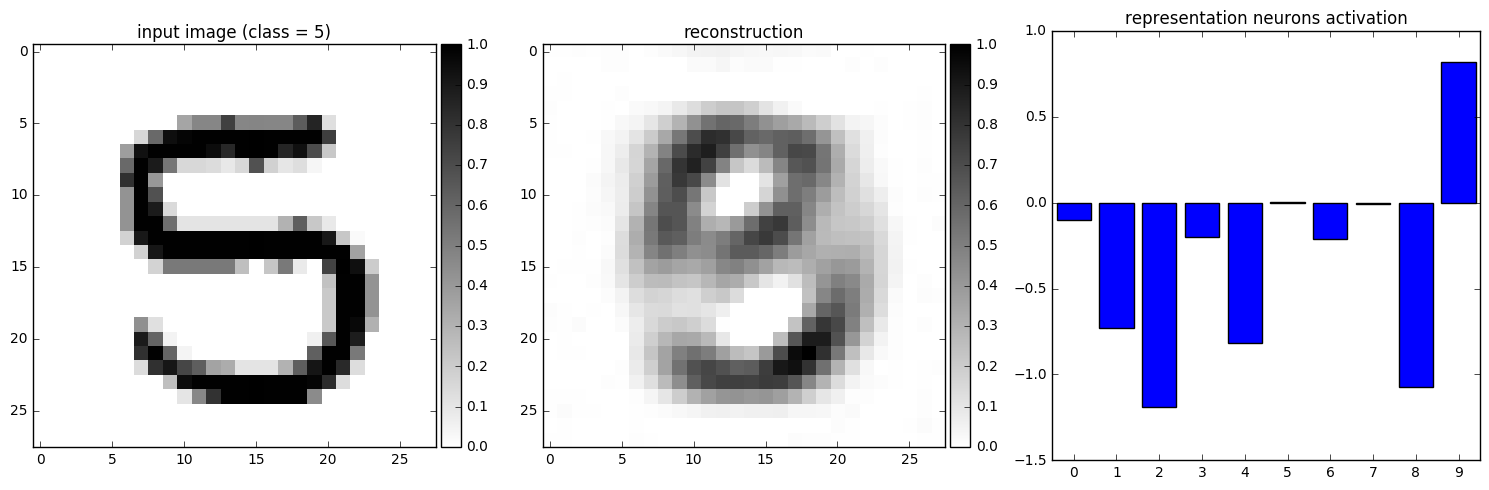

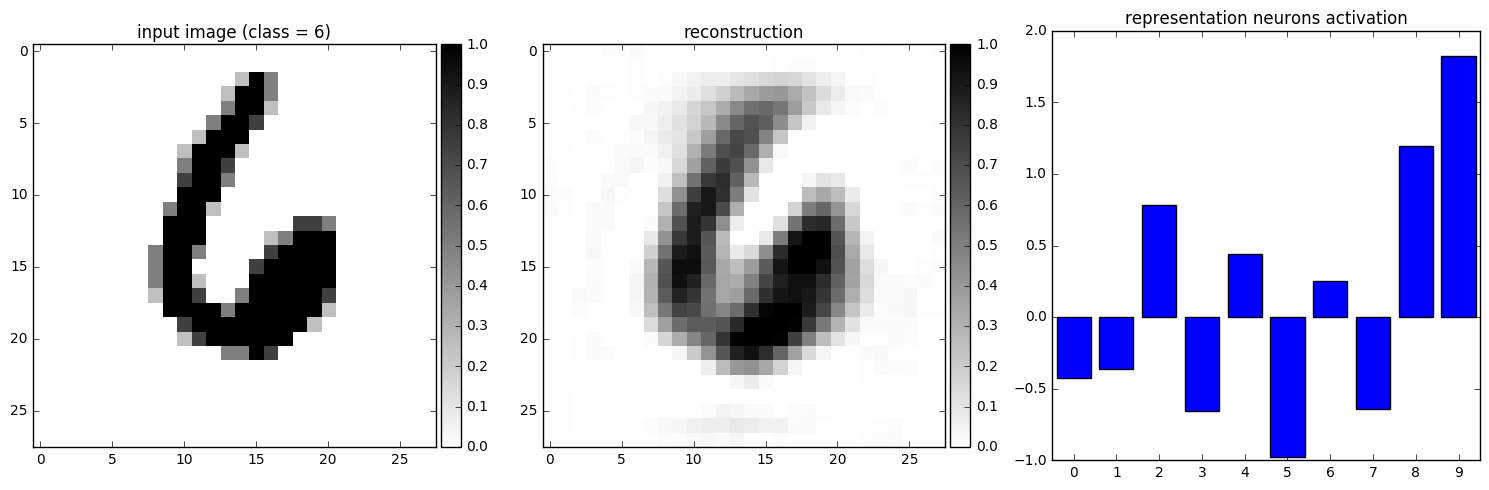

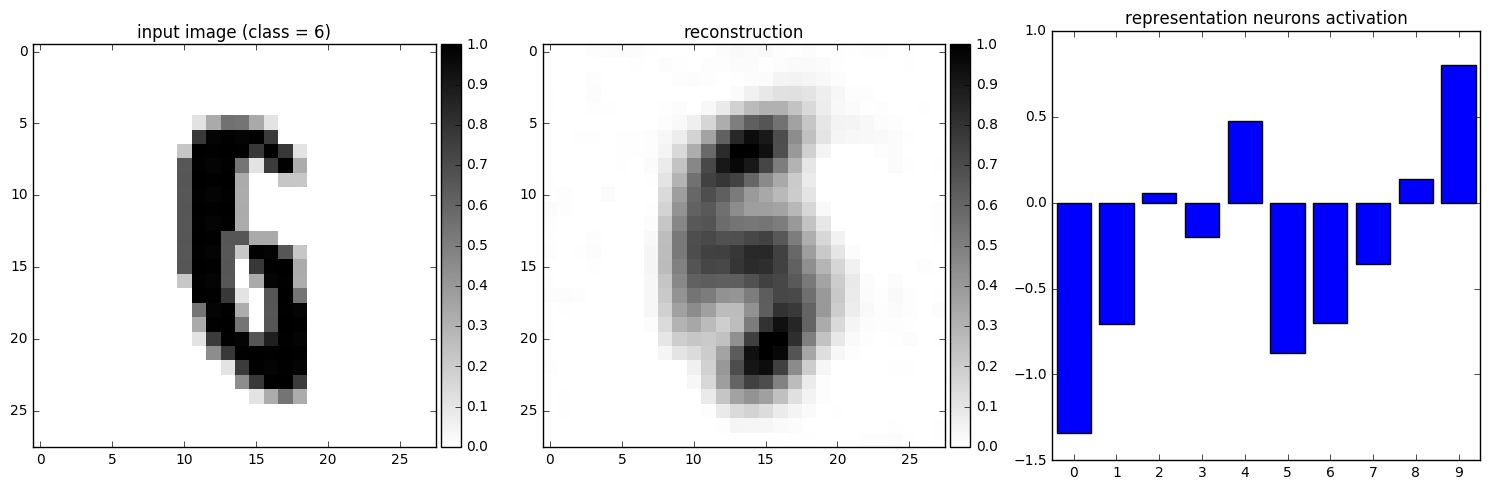

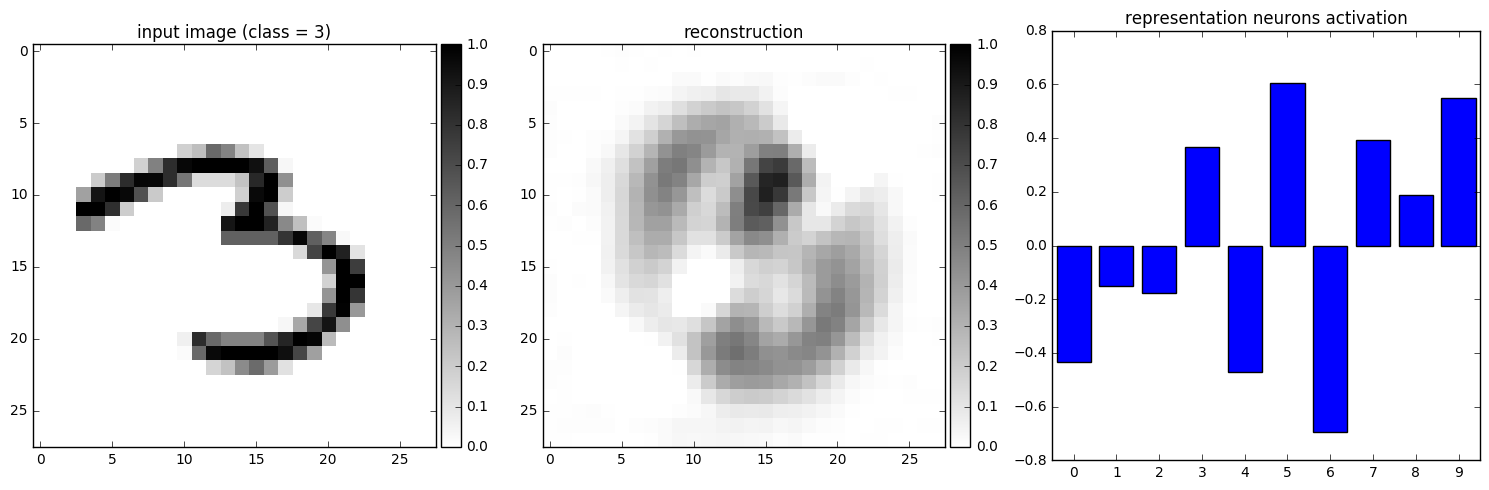

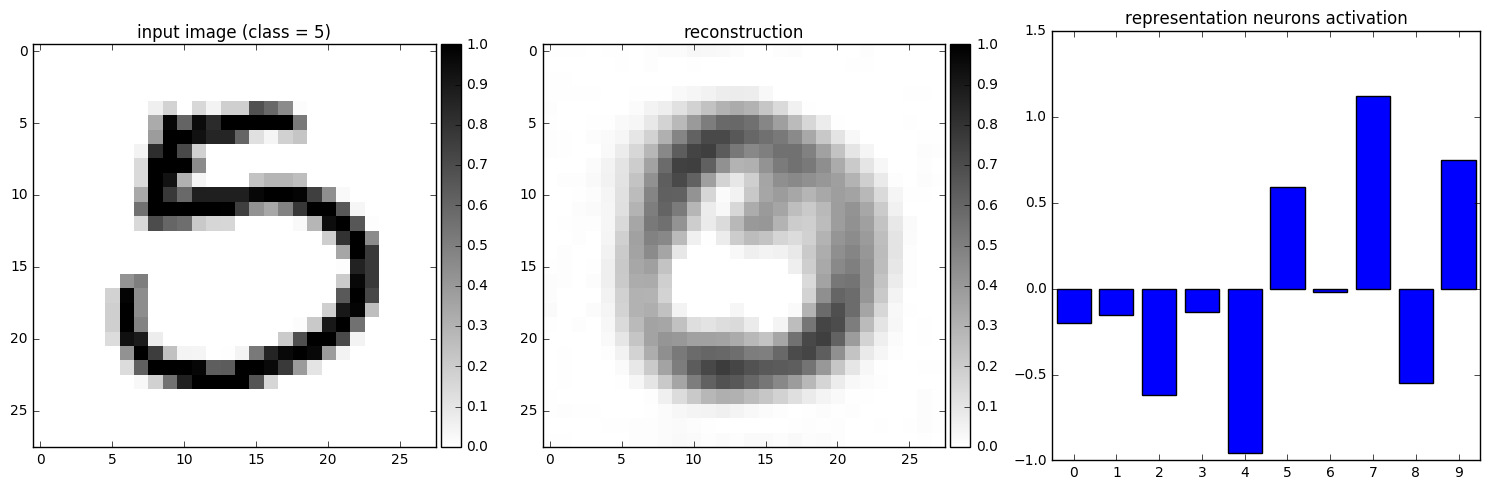

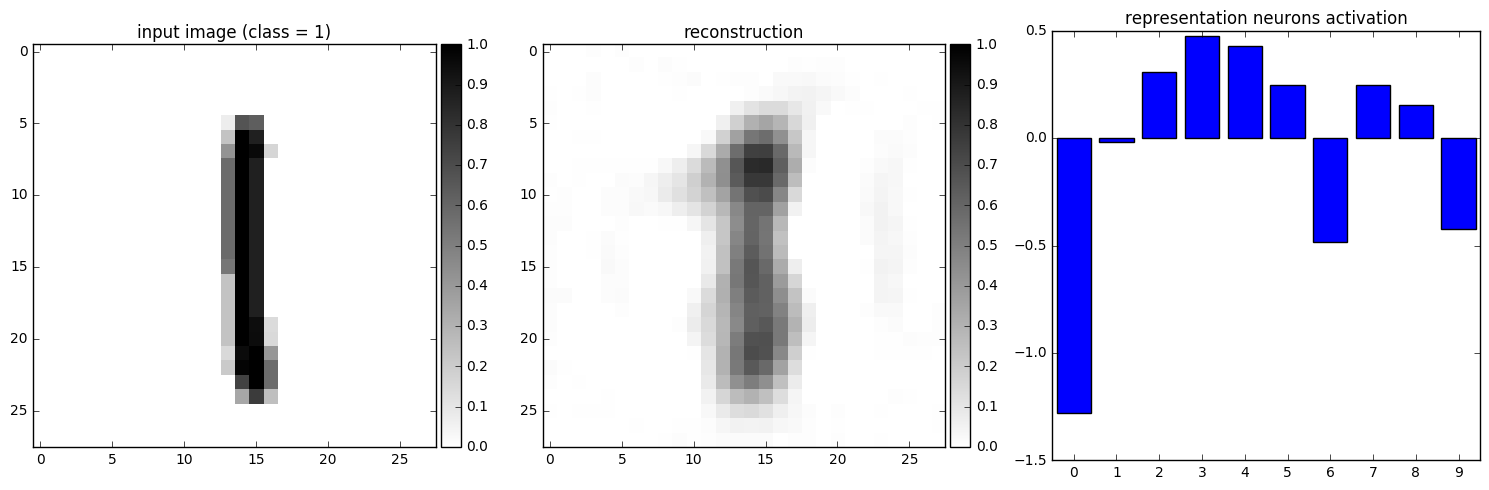

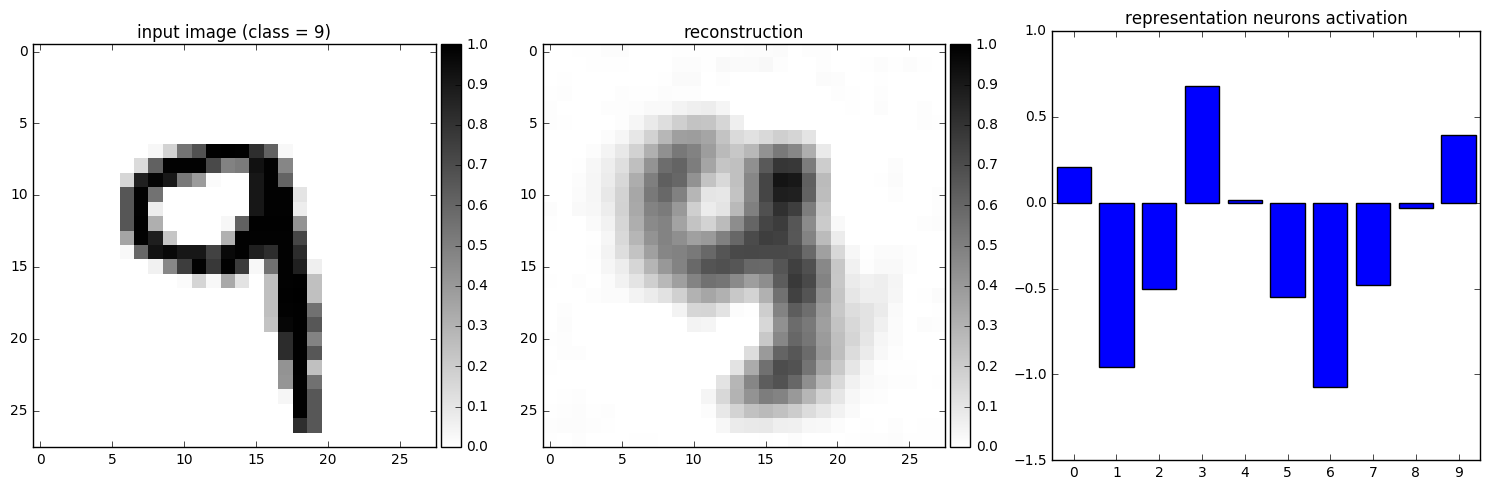

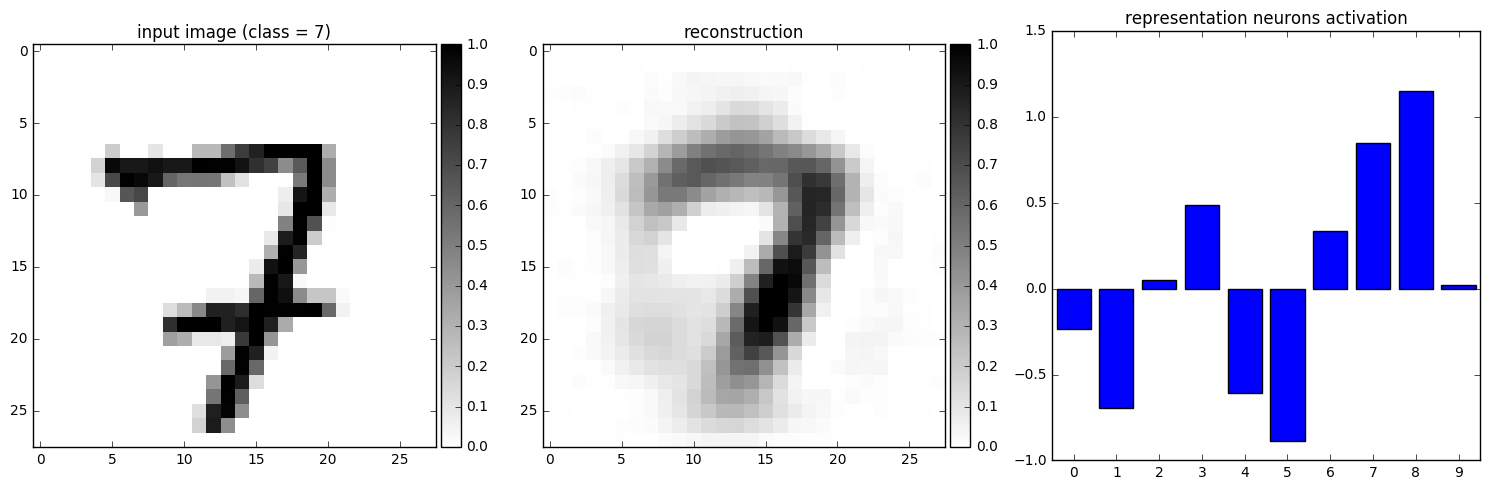

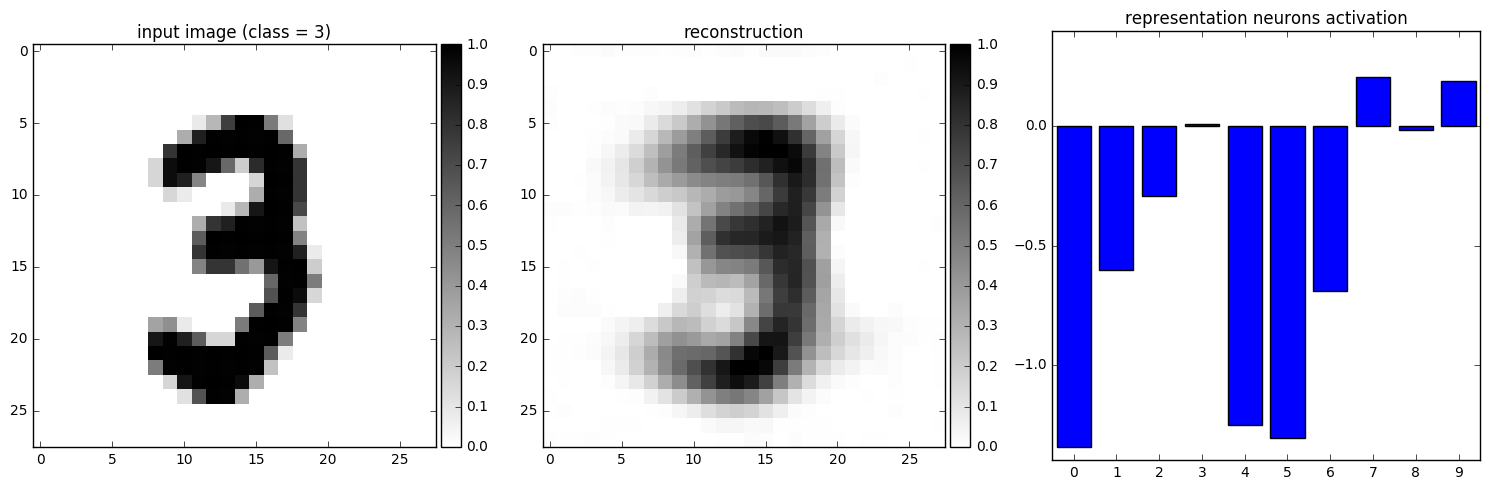

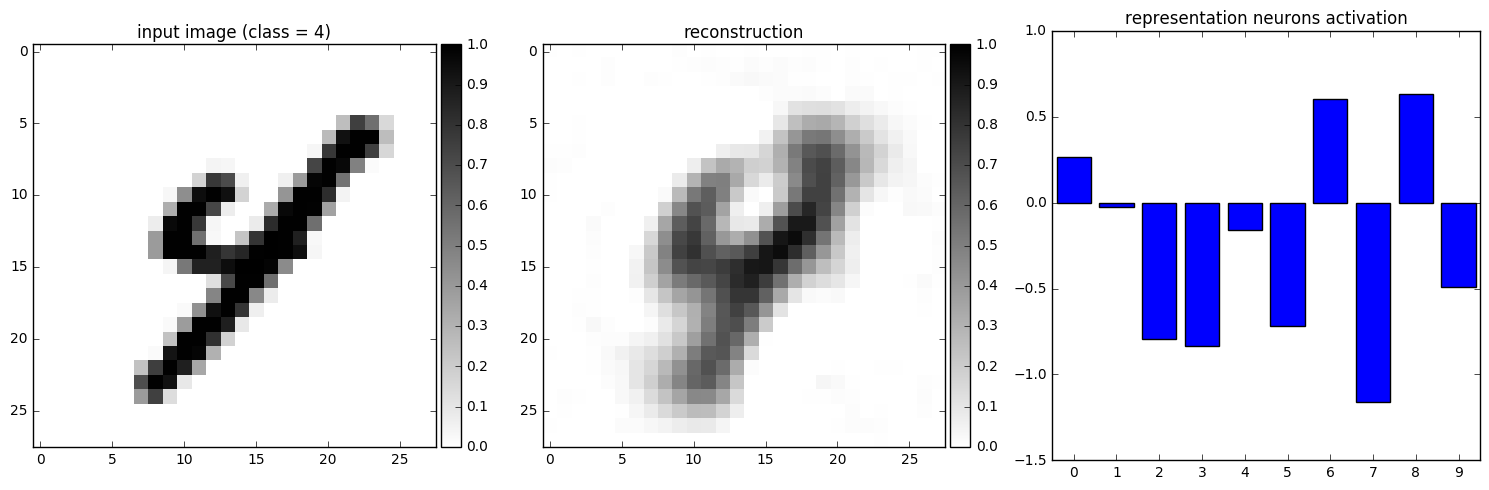

In [87]:
import random
indices = np.array(random.sample(range(X_test.shape[0]), 10))
X = X_test[indices]
X_pred = autoencoder.predict(X)
X_repr = encode([X])[0]

for i in range(X.shape[0]):
    compare_input_reconstruction(X[i].squeeze(), X_pred[i].squeeze(), X_repr[i],
                                clsname=y_test[indices[i]])

Now, for each class of digit, we can plot the average activation of each representation neuron. Unfortunately, as we see below (based on the error bars), it varies a lot.

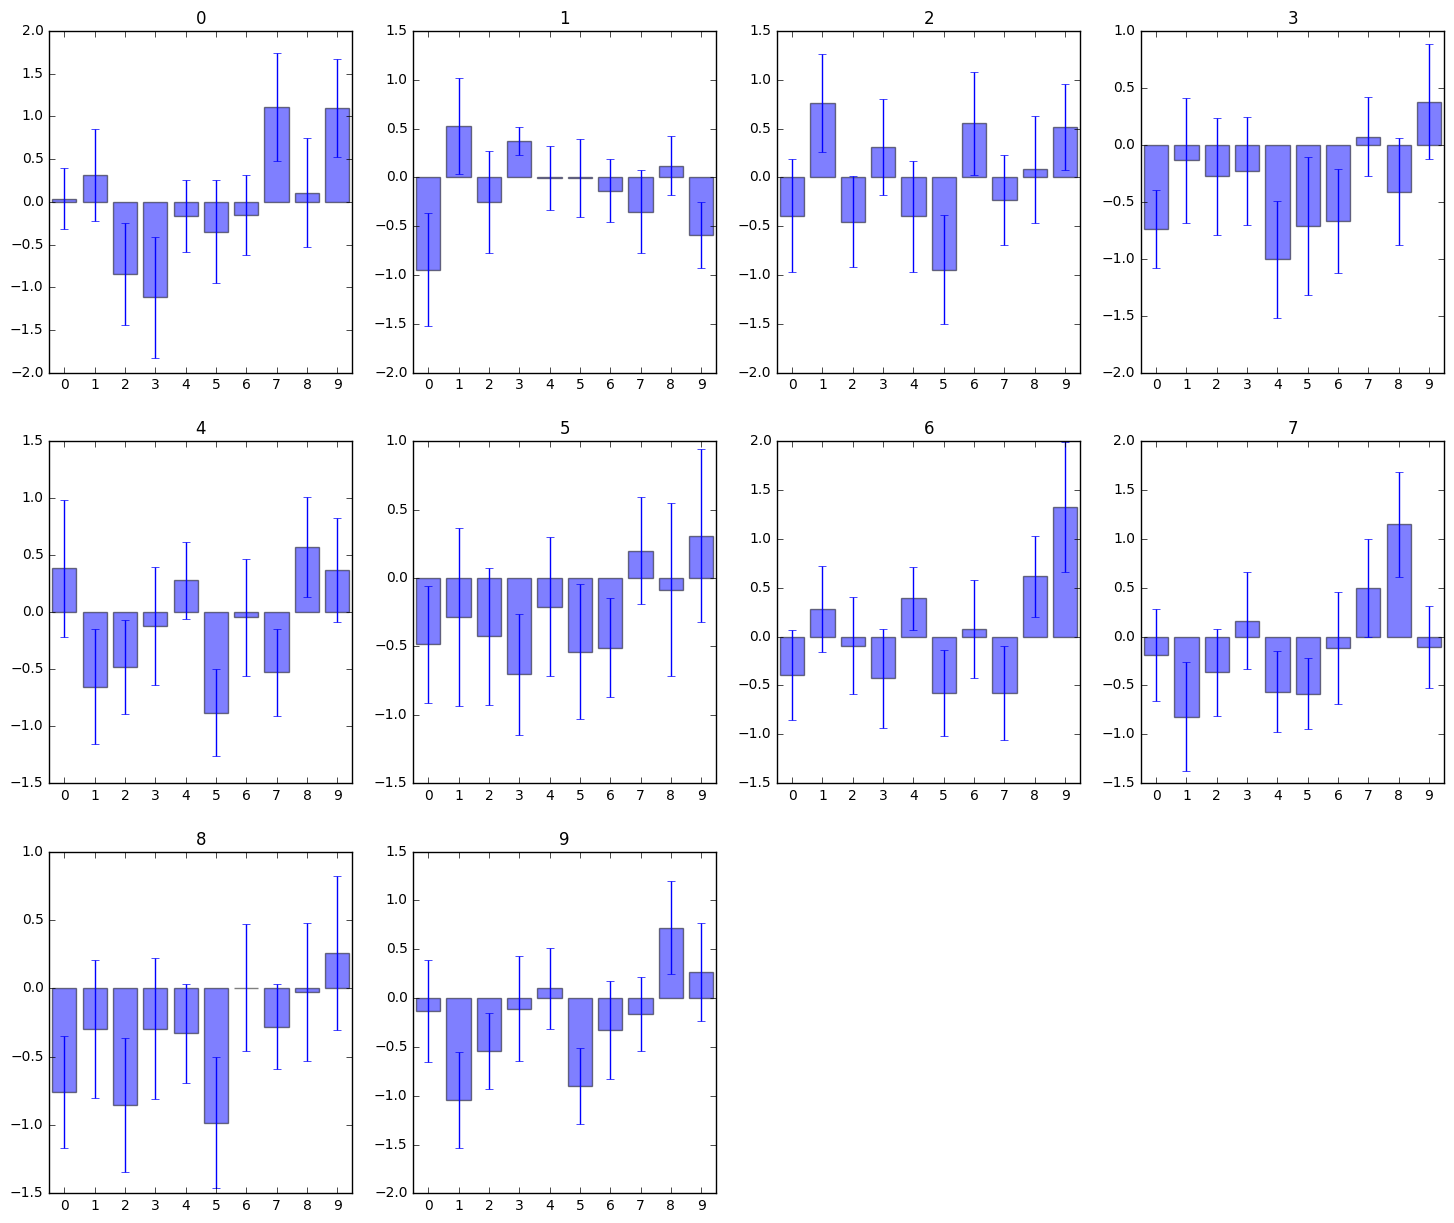

In [88]:
X_test_repr = encode([X_test])[0]

# For each label, plot an histogram of the encoding of
# all test example that belong to said label

pl.figure(figsize=(18, 15))
for label in np.unique(y_test):
    pl.subplot(3, 4, label + 1)
    pl.title(label)
    encodings = X_test_repr[y_test == label]
    
    # encodings is nexamples x 10
    means = np.mean(encodings, axis=0)
    stds = np.std(encodings, axis=0)
    
    bar_centers = np.arange(X_test_repr.shape[1])
    pl.bar(bar_centers, means, width=0.8, align='center', yerr=stds, alpha=0.5)
    pl.xticks(bar_centers, bar_centers)
    pl.xlim((-0.5, bar_centers[-1] + 0.5))
    #pl.ylim((0, 0.3))

By activating a single representation neuron at a time, we can get our decoder to generate parts of digits

In [89]:
# Build an decoder-only by copying the weights
decoder = models.Sequential()
decoder.add(Layer(input_shape=(10,)))
decoding_layers = create_decoding_layers()
for i, l in enumerate(decoding_layers):
    decoder.add(l)
decode = K.function([decoder.layers[0].input], [decoder.layers[-1].output])

# We have to set the weights *after* the model has been compiled (so after a call to K.function or model.compile)
trained_weights = [l.get_weights() for l in autoencoder.decoding_layers]
for i, l in enumerate(decoding_layers):
    l.set_weights(trained_weights[i])

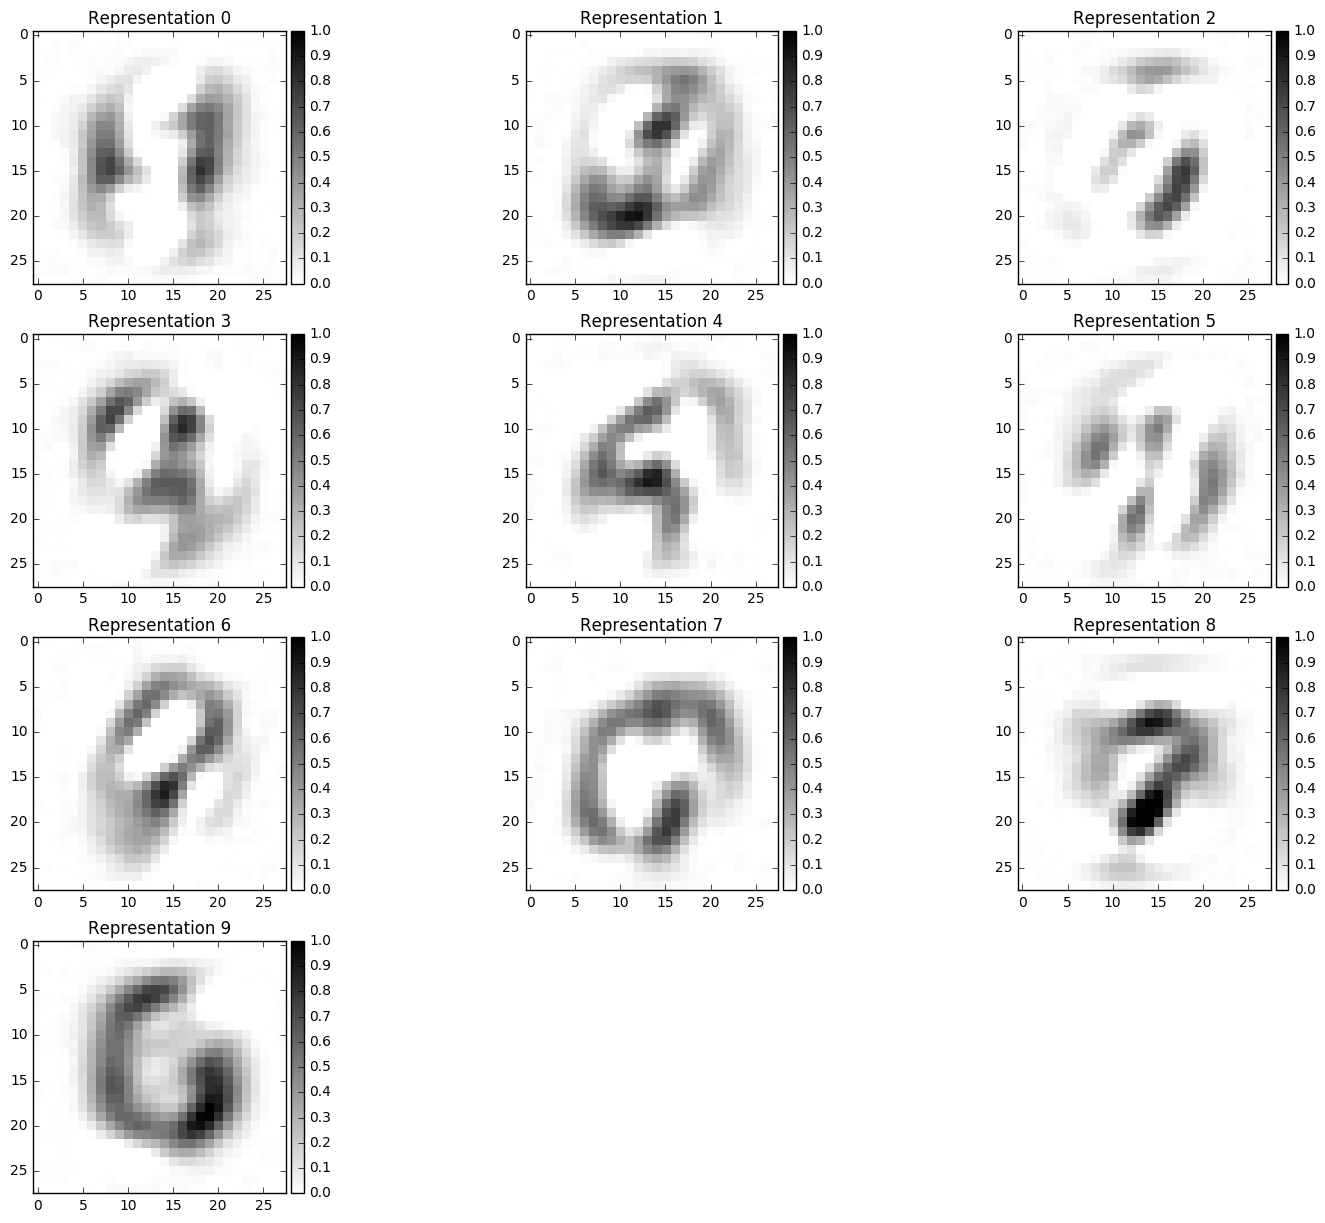

In [90]:
pl.figure(figsize=(18, 15))
for r in range(10):
    pl.subplot(4, 3, r + 1)
    X_enc = np.zeros((1, 10), dtype=np.float32)
    X_enc[:,r] = 2
    X_rec = decode([X_enc])[0]
    
    pl.title('Representation %d' % r)
    nice_imshow(pl.gca(), X_rec.squeeze(), vmin=0, vmax=1, cmap=cm.binary)

## With only 2 representation neurons

If we use only 2 representation neurons, the advantage is that we get make a 2D scatter plot of our data. The autoencoder performs dimensionality reduction.

In [118]:
# - Build the encoder pipeline
def create_encoding_layers():
    return [
        Convolution2D(32, 5, 5, border_mode='valid'),
        MaxPooling2D(pool_size=(2, 2)),
        Convolution2D(32, 3, 3, border_mode='valid'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128),
        Dense(2),
    ]

def create_decoding_layers():
    return[
        Dense(128),
        Dense(32*5*5),
        Reshape(target_shape=(32, 5, 5)),
        UpSampling2D(size=(2,2)),
        #UnPooling2D(size=(2,2)),
        ZeroPadding2D(padding=(1,1)),
        Convolution2D(32, 3, 3, border_mode='same'),
        UpSampling2D(size=(2,2)),
        #UnPooling2D(size=(2,2)),
        ZeroPadding2D(padding=(2,2)),
        Convolution2D(1, 5, 5, border_mode='same'),
    ]

autoencoder = models.Sequential()
# Add a noise layer to get a denoising autoencoder. This helps avoid overfitting
#autoencoder.add(Layer(input_shape=(1, 28, 28)))

autoencoder.add(GaussianNoise(sigma=0.3, input_shape=(1, 28, 28)))
autoencoder.encoding_layers = create_encoding_layers()
autoencoder.decoding_layers = create_decoding_layers()
for l in autoencoder.encoding_layers:
    autoencoder.add(l)
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01, momentum=0.8, decay=0., nesterov=False)
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta', metrics=["accuracy"])

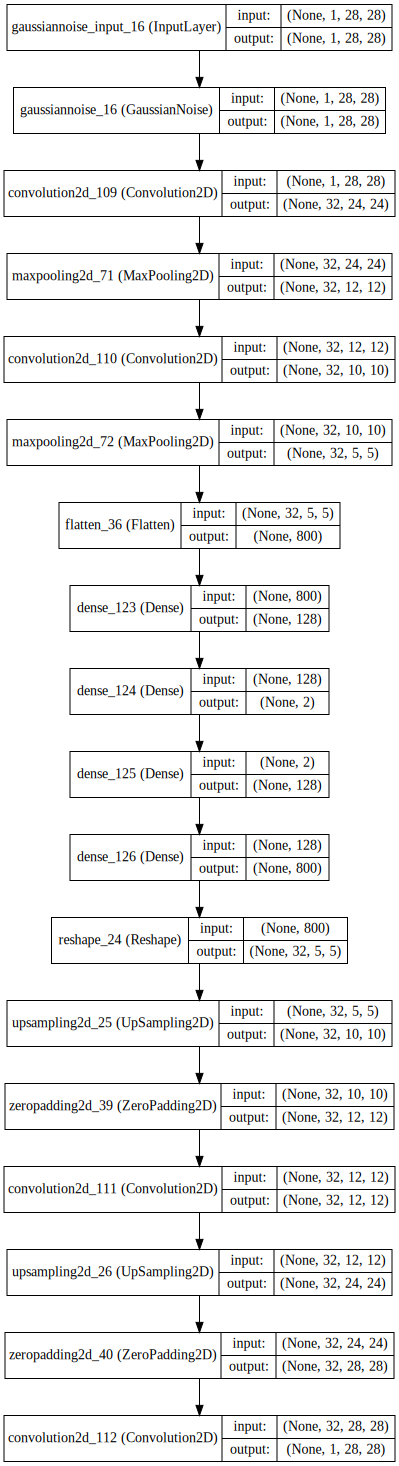

In [119]:
import keras.utils.visualize_util as vutil
from IPython.display import SVG

SVG(vutil.model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format="svg"))

In [120]:
nb_epoch = 10
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch,
                          verbose=1, validation_data=(X_test, X_test))
score = autoencoder.evaluate(X_test, X_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 46s - loss: 0.0602 - acc: 0.0871 - val_loss: 0.0576 - val_acc: 0.1039
Epoch 2/10
60000/60000 [==============================] - 46s - loss: 0.0570 - acc: 0.0996 - val_loss: 0.0567 - val_acc: 0.1036
Epoch 3/10
60000/60000 [==============================] - 46s - loss: 0.0566 - acc: 0.0995 - val_loss: 0.0565 - val_acc: 0.1062
Epoch 4/10
60000/60000 [==============================] - 46s - loss: 0.0565 - acc: 0.0998 - val_loss: 0.0566 - val_acc: 0.1065
Epoch 5/10
60000/60000 [==============================] - 46s - loss: 0.0564 - acc: 0.1005 - val_loss: 0.0567 - val_acc: 0.1048
Epoch 6/10
60000/60000 [==============================] - 46s - loss: 0.0564 - acc: 0.1010 - val_loss: 0.0563 - val_acc: 0.1058
Epoch 7/10
60000/60000 [==============================] - 46s - loss: 0.0564 - acc: 0.1027 - val_loss: 0.0561 - val_acc: 0.1067
Epoch 8/10
60000/60000 [==============================

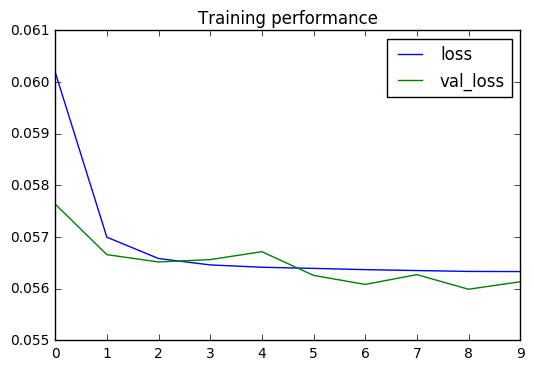

In [121]:
pl.figure()
pl.title('Training performance')
pl.plot(history.epoch, history.history['loss'], label='loss')
pl.plot(history.epoch, history.history['val_loss'], label='val_loss')
pl.legend()

In [122]:
# Build an encoder-only by copying the weights
encoder = models.Sequential()
encoder.add(Layer(input_shape=(1, 28, 28)))
encoding_layers = create_encoding_layers()
for i, l in enumerate(encoding_layers):
    encoder.add(l)
#encode = K.function([encoder.get_input(train=False)], [encoder.get_output(train=False)])
encode = K.function([encoder.layers[0].input], [encoder.layers[-1].output])

# We have to set the weights *after* the model has been compiled (so after a call to K.function or model.compile)
trained_weights = [l.get_weights() for l in autoencoder.encoding_layers]
for i, l in enumerate(encoding_layers):
    l.set_weights(trained_weights[i])

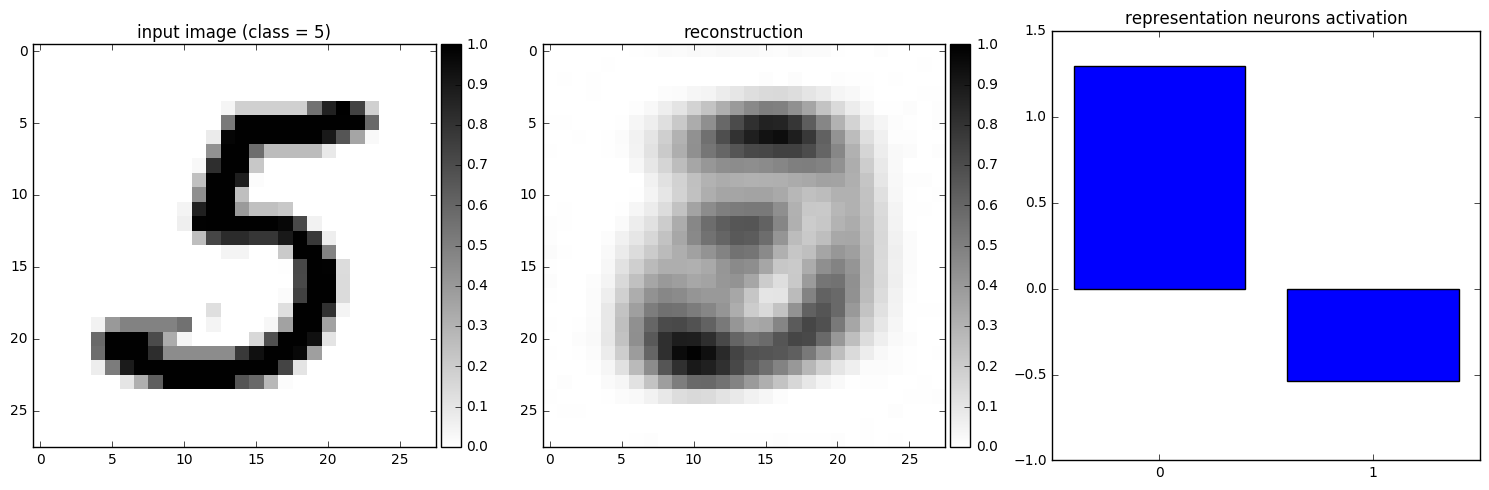

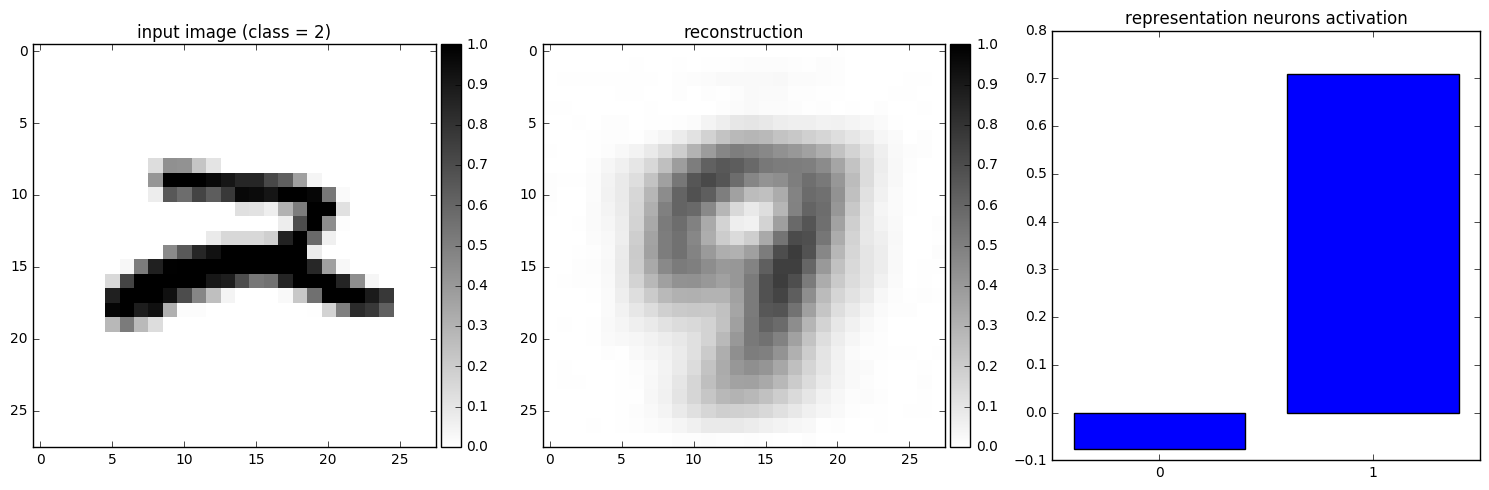

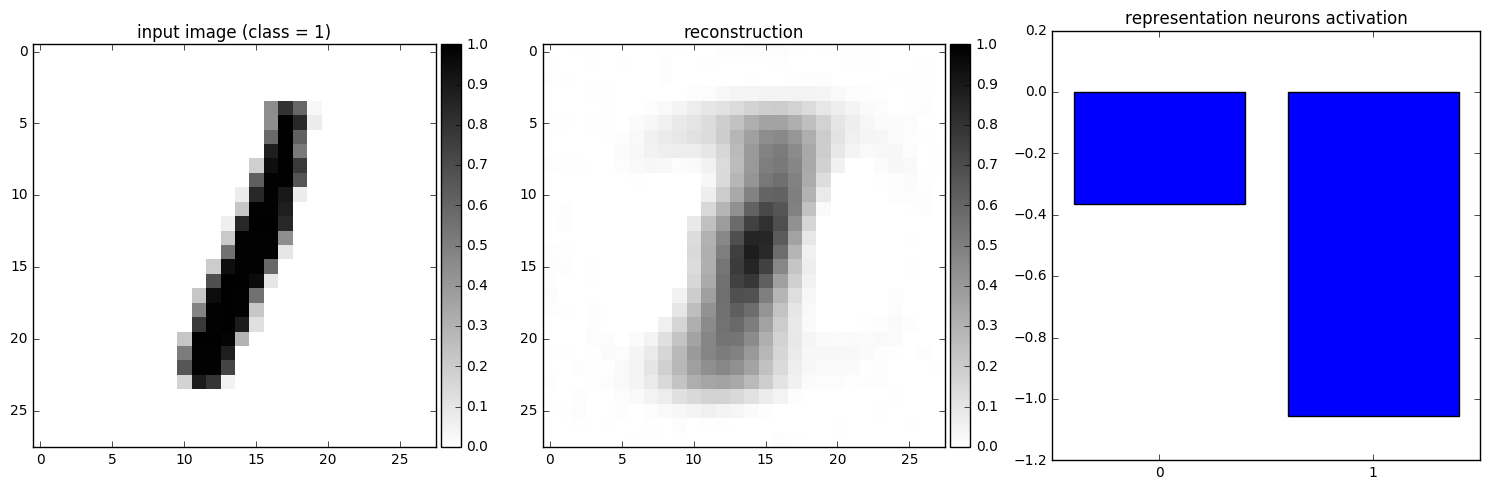

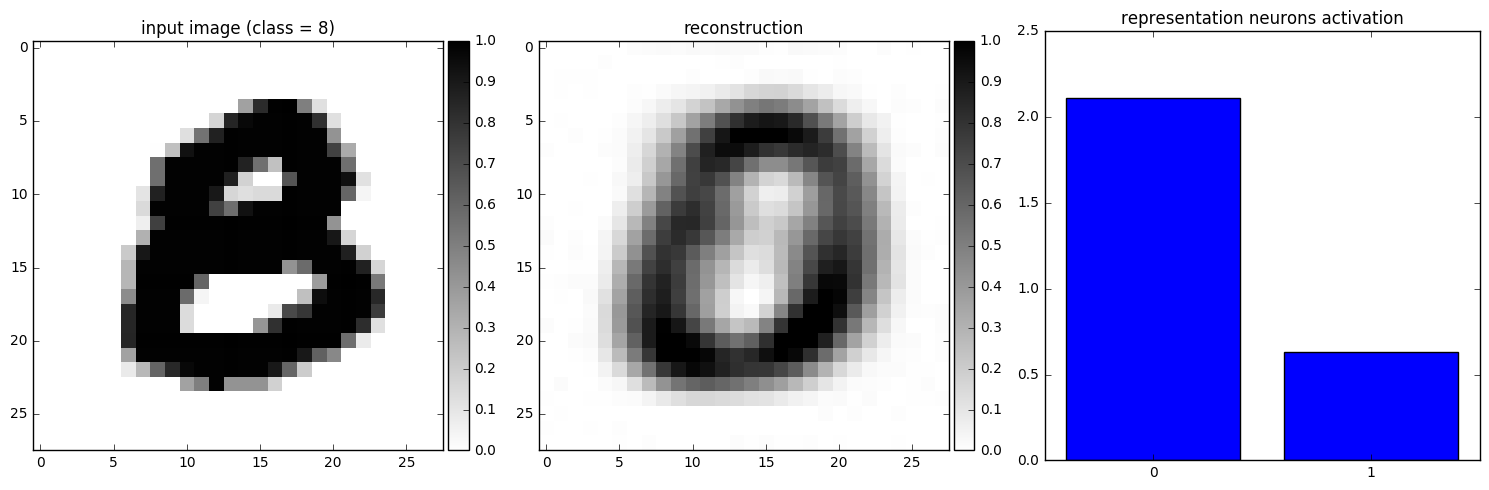

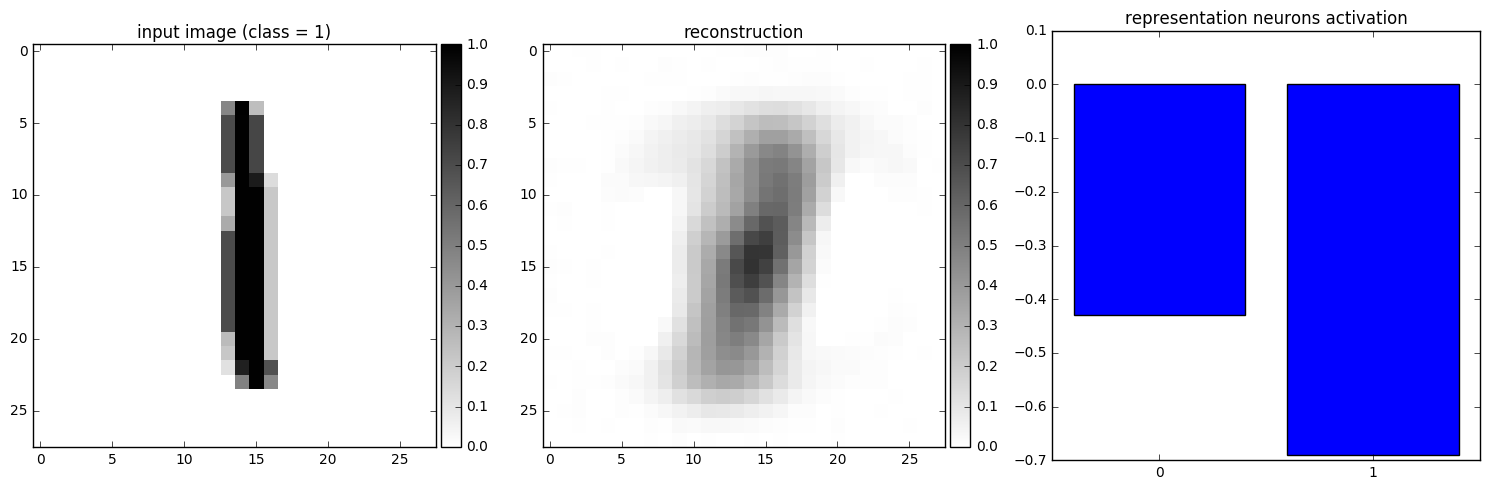

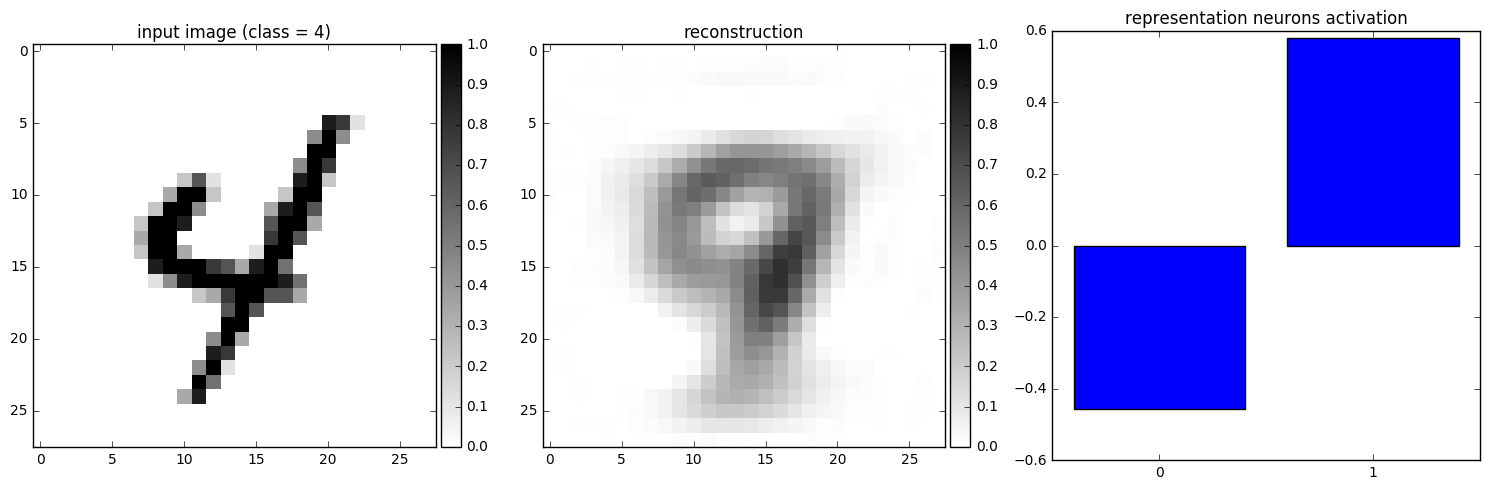

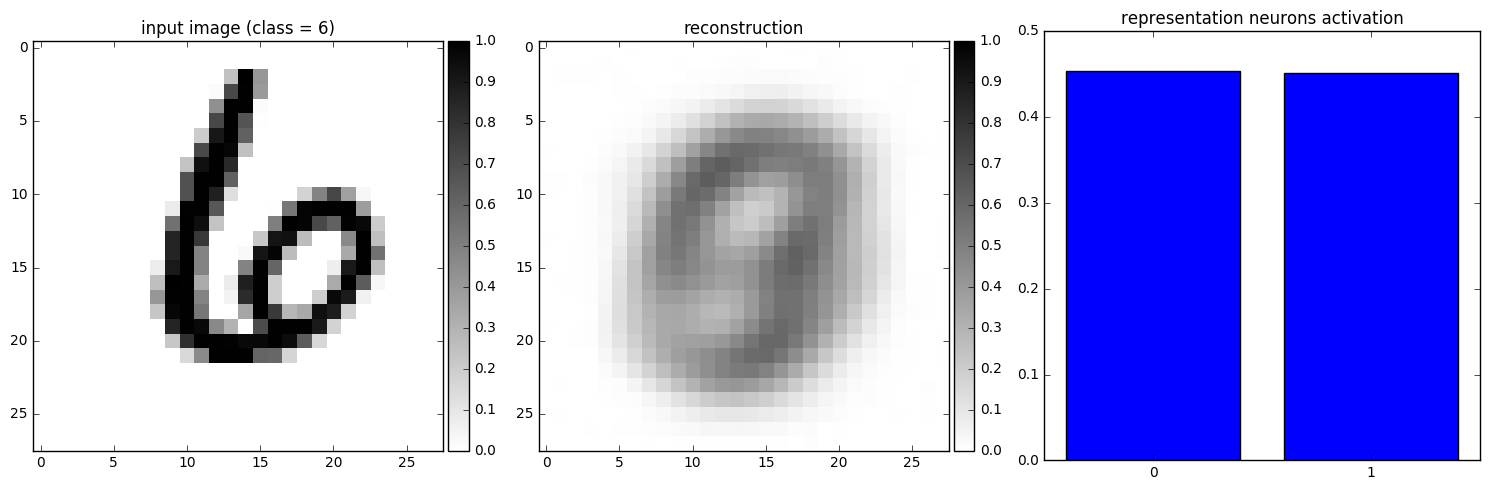

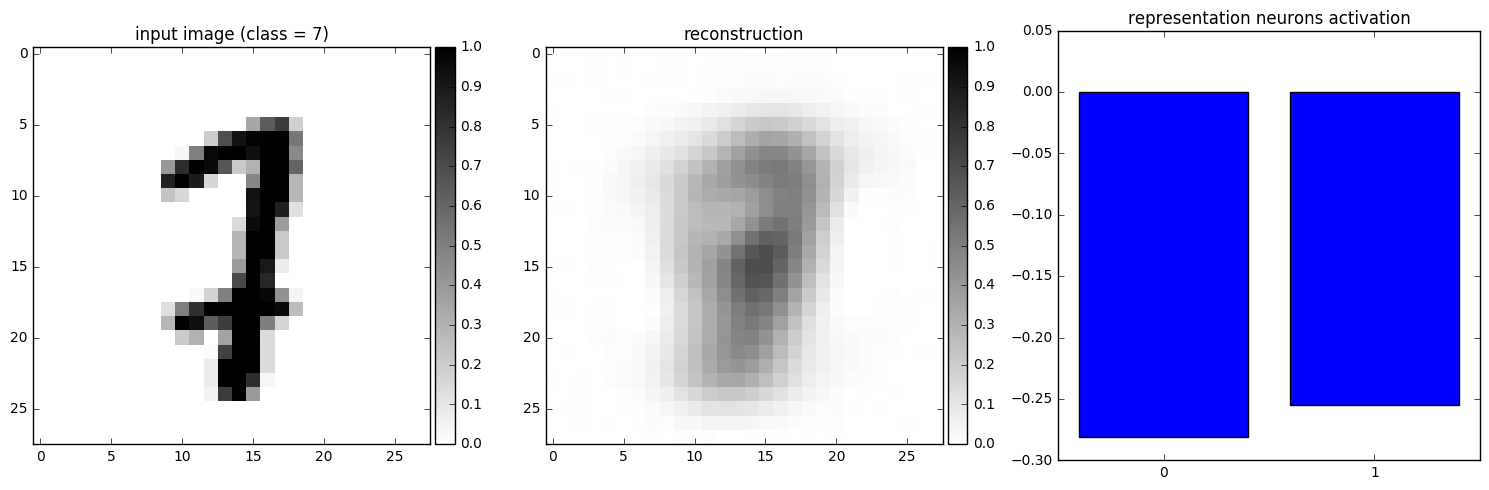

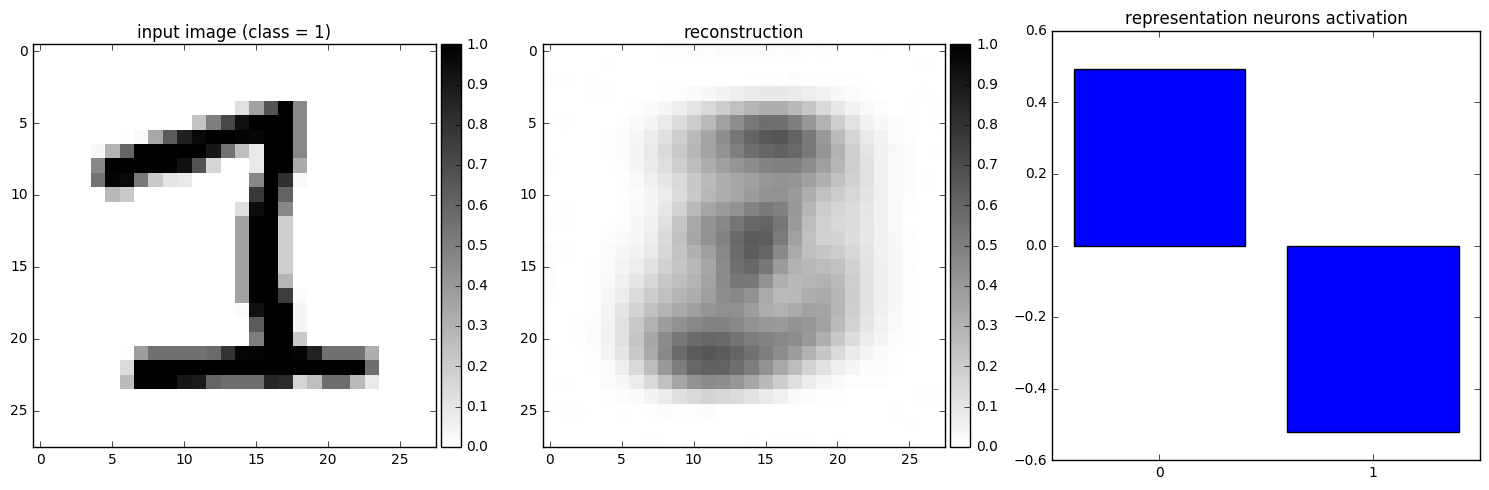

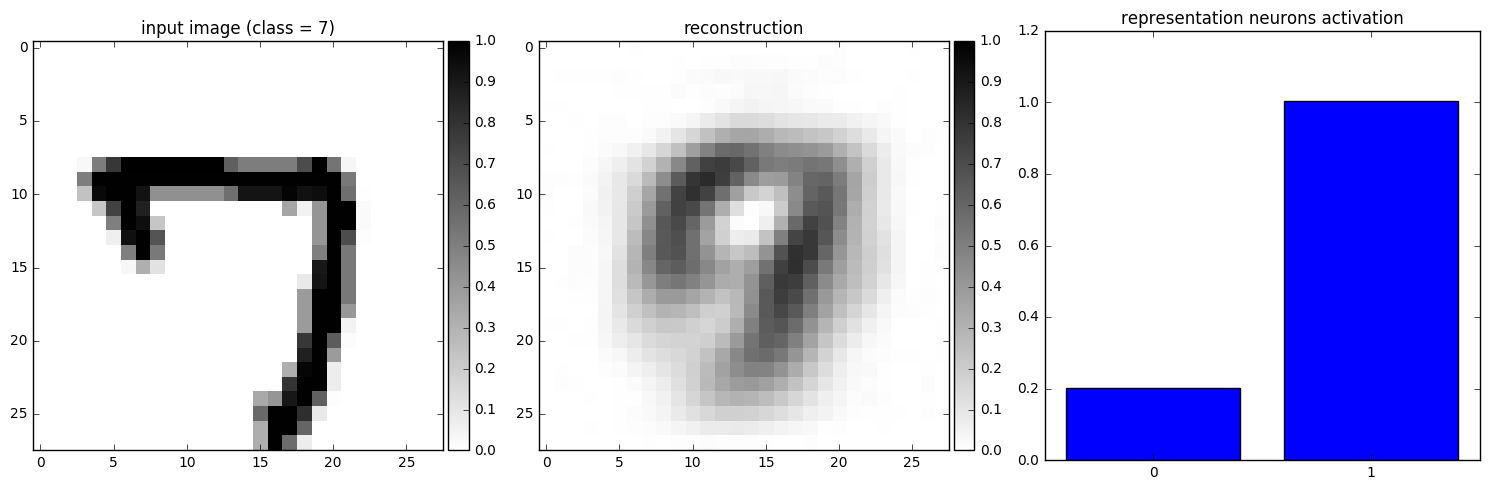

In [124]:
import random
indices = np.array(random.sample(range(X_test.shape[0]), 10))
X = X_test[indices]
X_pred = autoencoder.predict(X)
X_repr = encode([X])[0]

for i in range(X.shape[0]):
    compare_input_reconstruction(X[i].squeeze(), X_pred[i].squeeze(), X_repr[i],
                                clsname=y_test[indices[i]])

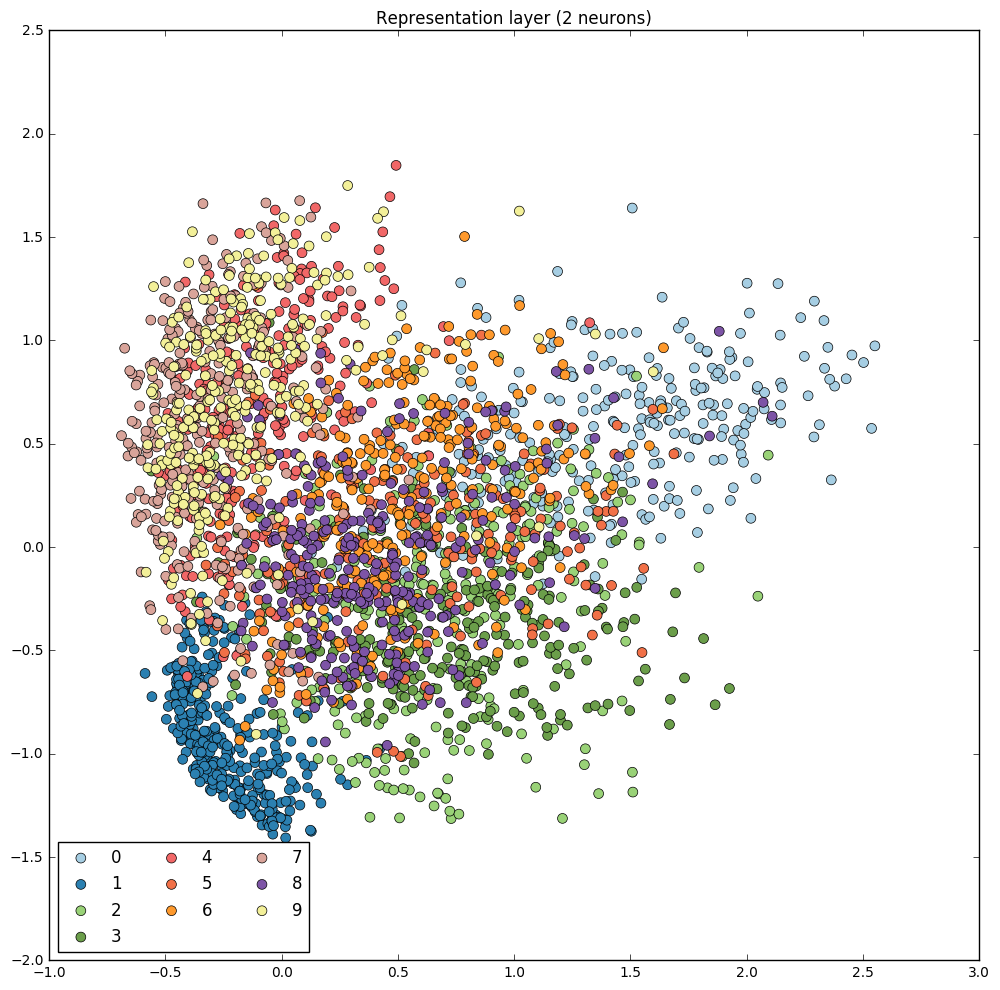

In [126]:
X_test_repr = encode([X_test])[0]

import matplotlib as mpl

indices = random.sample(range(X_test_repr.shape[0]), 3000)
points = X_test_repr[indices]
labels = y_test[indices]

norm = mpl.colors.Normalize(vmin=0, vmax=10)
m = cm.ScalarMappable(norm=norm, cmap=cm.Paired)
colors = m.to_rgba(labels)

pl.figure(figsize=(12, 12))
pl.title('Representation layer (2 neurons)')

scatters = []
for lid in np.unique(labels):
    mask = labels == lid
    sc = pl.scatter(points[mask, 0], points[mask, 1], c=colors[mask], linewidth=0.5, s=50)
    scatters.append(sc)
pl.legend(scatters, np.arange(10), scatterpoints=1, loc='lower left', ncol=3, fontsize=12)